<a href="https://colab.research.google.com/github/cschwi/ds_job_app/blob/main/EMNIST_Final_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for EMNIST

In [ ]:
import os

import numpy as np
import requests
import pickle

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torchvision

# Setting seed for reproducibility
torch.manual_seed(123987)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", device)

device: cuda


# Loading EMNIST data


In [ ]:
emnist_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    # There was more here
])

In [ ]:
## Loading EMNIST data
## PyTorch uses the Dataset class from torch.utils.data to handle access to datasets
data_train = torchvision.datasets.EMNIST( # Training set
    root='./data/',
    train=True,
    download=True,
    transform=emnist_transform,  # rotates images
    split='letters'
)

data_test = torchvision.datasets.EMNIST( # Testing set
    root='./data/',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    split='letters'
)

100%|██████████| 562M/562M [00:07<00:00, 75.3MB/s]


Let us examine the sizes of the two datasets as well as the shape of their elements, to get a better idea of the data and make sure it was loaded properly.

In [ ]:
print(f"Number of training images: {len(data_train)}")
print(f"Number of test images:     {len(data_test)}")
print()
print("Each data element is an (image, label) pair.")
print(f"Shape of each image: {data_train[0][0].shape}")

Number of training images: 124800
Number of test images:     20800

Each data element is an (image, label) pair.
Shape of each image: torch.Size([1, 28, 28])


To get a better idea of what the elements in a dataset look like, let us plot several EMNIST images.

In [ ]:
import matplotlib.pyplot as plt

# Plotting function.  The argument 'images' is a tensor of
# the form [1,28,28].  For plotting, we need flattened tensor
# of the shape [28,28].  Hence, we use 'images[i][0]' in the
# call of 'plt.imshow' below.
def plot_data(images, labels):
    cols, rows = 3, 3
    for i in range(cols * rows):
        plt.subplot(cols, rows, i + 1)
        plt.tight_layout()
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.xticks([])
        plt.yticks([])
        plt.axis("off")
    plt.show()

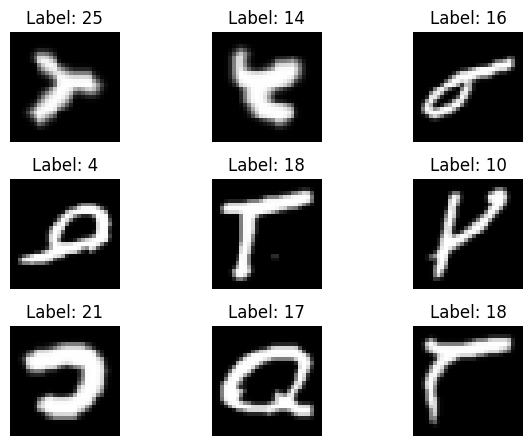

In [ ]:
# Get a list of 9 images and their labels from the train data
# starting from the index 'start_idx'
start_idx = 500 #10994 59915

data_subset = [data_train[i] for i in range(start_idx, start_idx + 9)]
images, labels = zip(*data_subset)

plot_data(images, labels)

Shape of images is: torch.Size([64, 1, 28, 28])
Shape of labels is: torch.Size([64])



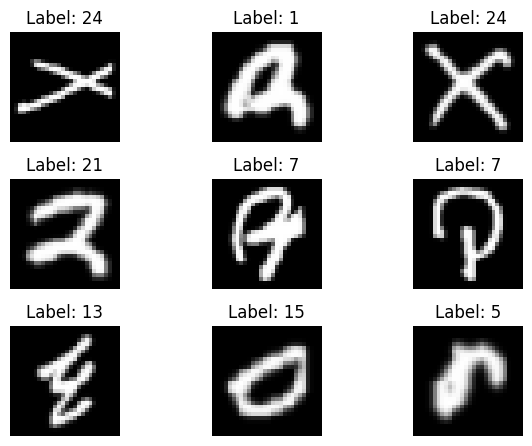

In [ ]:
# Batch sizes for training and evaluation
batch_size_train = 64
batch_size_test  = 1000

# We can use PyTorch dataloaders to get batches from datasets
loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
loader_test  = torch.utils.data.DataLoader(data_test,  batch_size=batch_size_test,  shuffle=False)

# Create an iterator and draw the next batch
images, labels = next(iter(loader_train))
print(f"Shape of images is: {images.shape}")
print(f"Shape of labels is: {labels.shape}")
print()
plot_data(images, labels)

# Architecture

Next, we create the convolutional neural network (CNN) model to be used for the letter recognition.

In [ ]:
class CNNet(nn.Module):
  #pass
  def __init__(self, input_size=28 * 28, hidden_sizes = (), output_size=27):
      super(CNNet, self).__init__()
      self.flatten = nn.Flatten()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=1)
      self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
      self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
      self.pool1 = nn.MaxPool2d(kernel_size=2)
      self.pool2 = nn.MaxPool2d(kernel_size=2)
      self.norm = nn.BatchNorm2d(num_features=32)
      self.fc1 = nn.Linear(in_features=1152, out_features=128)

  def forward(self, x):
      #x = self.flatten(x)
      x = F.relu(self.conv1(x))
      x = self.pool1(x)
      x = F.relu(self.conv2(x))
      x = self.pool2(x)
      x = self.norm(x)
      x = F.relu(self.conv3(x))
      x = self.flatten(x)
      x = self.fc1(x)
      return x

In [ ]:
cnn_model = CNNet().to(device)

In [ ]:
images, labels = next(iter(loader_train))
print(f"Shape of images is: {images.shape}")
print(f"Shape of labels is: {labels.shape}")
print()

Shape of images is: torch.Size([64, 1, 28, 28])
Shape of labels is: torch.Size([64])



In [ ]:
x = images
conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=1)
x = conv1(x)
print(x.shape)

torch.Size([64, 16, 26, 26])


In [ ]:
conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
x = conv2(x)
print(x.shape)

torch.Size([64, 32, 26, 26])


In [ ]:
conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
x = conv3(x)
print(x.shape)

torch.Size([64, 32, 26, 26])


In [ ]:
flatten = nn.Flatten()
x = flatten(x)

print(x.shape)

# Apply the fully connected layer
fc1 = nn.Linear(in_features=32*26*26, out_features=128)
x = fc1(x)
print(x.shape)

torch.Size([64, 21632])
torch.Size([64, 128])


# Training

In [ ]:
# Train 'model' through batches in one epoch using the 'criterion' loss function,
# on the training dataset produced by the 'loader'.
def train(model, criterion, optimizer, loader, epoch):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch: {epoch+1}/{num_epochs}   Training loss: {running_loss/len(loader) :.6f}")

In [ ]:
# Use the cross entropy loss for the multi-class classification
criterion = nn.CrossEntropyLoss()

# SGD optimization hyperparameters
learning_rate = 0.1
weight_decay = 0.001

# Number of epochs for training
num_epochs = 4

In [ ]:
# CNNet
optimizer_cnn = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

for epoch in range(num_epochs):
    train(cnn_model, criterion, optimizer_cnn, loader_train, epoch)

Epoch: 1/4   Training loss: 0.390582
Epoch: 2/4   Training loss: 0.220953
Epoch: 3/4   Training loss: 0.196441
Epoch: 4/4   Training loss: 0.185550


# Testing

In [ ]:
# Test the model
def test(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0) # labels.size() is [1000]
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

In [ ]:
# Run the test function
test(cnn_model, loader_test)

Accuracy: 92.56%


In [ ]:
# In case we wish to have a summary
from torchsummary import summary
summary(cnn_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             416
         MaxPool2d-2           [-1, 16, 13, 13]               0
            Conv2d-3           [-1, 32, 13, 13]           4,640
         MaxPool2d-4             [-1, 32, 6, 6]               0
       BatchNorm2d-5             [-1, 32, 6, 6]              64
            Conv2d-6             [-1, 32, 6, 6]           9,248
           Flatten-7                 [-1, 1152]               0
            Linear-8                  [-1, 128]         147,584
Total params: 161,952
Trainable params: 161,952
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 0.62
Estimated Total Size (MB): 0.80
----------------------------------------------------------------
